In [1]:
# import library
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [2]:
# create ticker object and fetch historical market data
def ticker_history(comp, dt):
    ticker = yf.Ticker(comp)
    df = ticker.history(period=dt)
    return df

In [3]:
# split data into training and test data
def train_test_split(df, tSplit, col):
    train = df.loc[:f'{tSplit}', col].values
    test = df.loc[f'{tSplit+1}':, col].values
    return train, test

In [4]:
# standardize training data
def scale_fit_transform(train, scaler):
    train = train.reshape(-1, 1)
    trainStd = scaler.fit_transform(train)
    return trainStd

In [5]:
# convert training data to inputs and outputs
def split_time_series(seq, step):
    X, y = list(), list()
    for i in range(len(seq)):
        end = i + step
        if end > len(seq) - 1:
            break
        xSeq, ySeq = seq[i:end], seq[end]
        X.append(xSeq)
        y.append(ySeq)
    return np.array(X), np.array(y)

In [6]:
# create LSTM model
def model_lstm(step, feature, unit):
    lstm = Sequential()
    lstm.add(LSTM(units=100, activation='tanh', input_shape=(step, feature)))
    lstm.add(Dense(units=unit))
    lstm.compile(optimizer='adam', loss='mse')
    return lstm

In [7]:
# transform test data into samples and inverse transform predictions
def predict_lstm(df, test, XTest, yTest, col, lstm, scaler, step, feature):
    dfTot = df.loc[:,col]
    dIn = dfTot[len(dfTot) - len(test) - step :].values
    dIn = dIn.reshape(-1, 1)
    dIn = scaler.transform(dIn)
    XTest, yTest = split_time_series(dIn, step)
    XTest = XTest.reshape(XTest.shape[0], XTest.shape[1], feature)
    yPred = lstm.predict(XTest)
    yPred = scaler.inverse_transform(yPred)
    return XTest, yTest, yPred

In [8]:
comp = ['NVDA', 'AMD']
cols = ['Open', 'High', 'Low', 'Close']
col = cols[1]
dt = '5y'
tSplit = 2023
step = 60
feature = 1
scaler = MinMaxScaler(feature_range=(0, 1))

In [9]:
# create dataframe
dfNVDA = ticker_history(comp[0], dt)
dfAMD = ticker_history(comp[1], dt)

trainNVDA, testNVDA = train_test_split(dfNVDA, tSplit, col)
trainAMD, testAMD = train_test_split(dfAMD, tSplit, col)

trainStdNVDA = scale_fit_transform(trainNVDA, scaler)
trainStdAMD = scale_fit_transform(trainAMD, scaler)

XTrainNVDA, yTrainNVDA = split_time_series(trainStdNVDA, step)
XTrainAMD, yTrainAMD = split_time_series(trainStdAMD, step)

# reshape training data to fit on LSTM model
XTrainNVDA = XTrainNVDA.reshape(XTrainNVDA.shape[0], XTrainNVDA.shape[1], feature)
XTrainAMD = XTrainAMD.reshape(XTrainAMD.shape[0], XTrainAMD.shape[1], feature)

In [10]:
lstmNVDA = model_lstm(step, feature, 1)
lstmAMD = model_lstm(step, feature, 1)

# train the model
lstmNVDA.fit(XTrainNVDA, yTrainNVDA, epochs=10, batch_size=32)
lstmAMD.fit(XTrainAMD, yTrainAMD, epochs=10, batch_size=32)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0670
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0024
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0012
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0013
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0012
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0013
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0012
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 9.9430e-04
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 9.4985e-04
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 9.6765e-04
Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0672
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0040
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0023
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0021
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0021
Epoch 6/

In [11]:
XTestNVDA, yTestNVDA, yPredNVDA = predict_lstm(dfNVDA, testNVDA, XTrainNVDA, yTrainNVDA, col, lstmNVDA, scaler, step, feature)
XTestAMD, yTestAMD, yPredAMD = predict_lstm(dfAMD, testAMD, XTrainAMD, yTrainAMD, col, lstmAMD, scaler, step, feature)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [12]:
def plot_train_test(df, tSplit, col, name):
    df.loc[:f'{tSplit}', col].plot(figsize=(14, 4), legend=True)
    df.loc[f'{tSplit+1}':, col].plot(figsize=(14, 4), legend=True)
    plt.legend([f'Train ( - {tSplit+1})', f'Test ({tSplit+1} - )'])
    plt.title(f'{name} Stock Price')
    plt.show()

In [13]:
def plot_predict(test, predict, name):
    plt.plot(test, label='Real')
    plt.plot(predict, label='Predict')
    plt.title(f'{name} Stock Price Prediction')
    plt.xlabel('Day')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

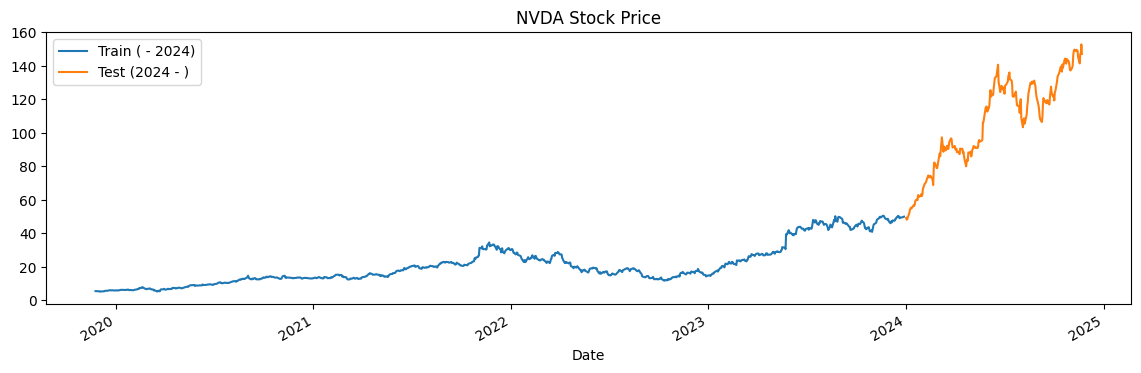

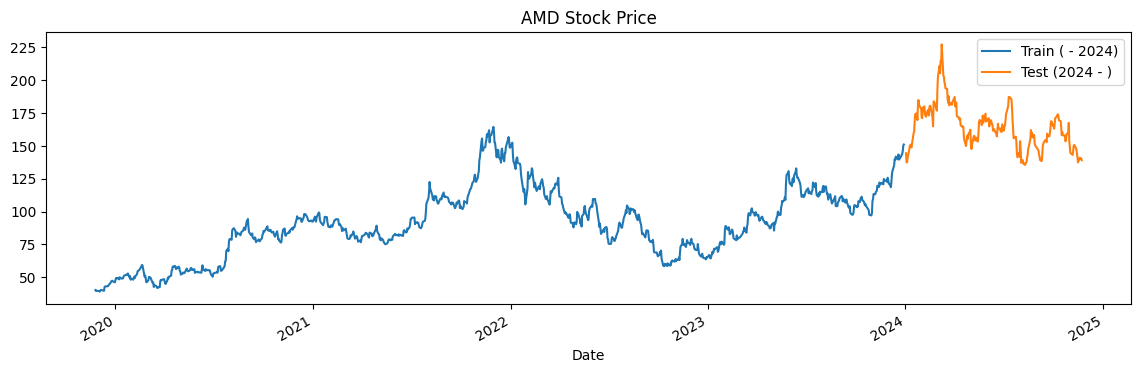

In [14]:
plot_train_test(dfNVDA, tSplit, col, comp[0])
plot_train_test(dfAMD, tSplit, col, comp[1])

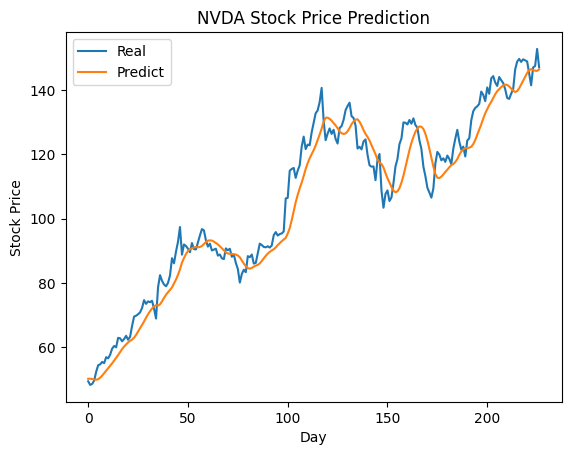

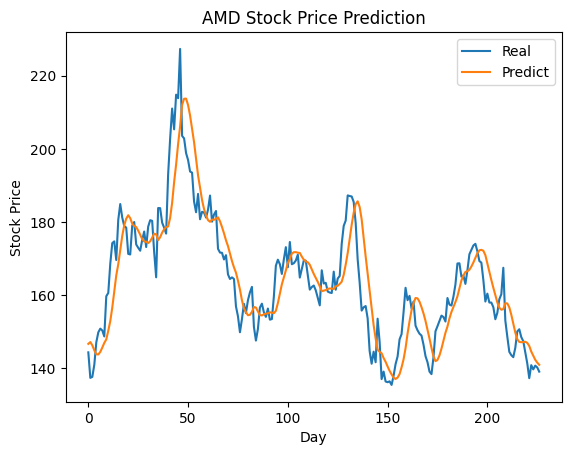

In [15]:
plot_predict(testNVDA, yPredNVDA, comp[0])
plot_predict(testAMD, yPredAMD, comp[1])

In [16]:
print('root mean squared error')
print("NVDA: {}".format(np.sqrt(mean_squared_error(testNVDA, yPredNVDA))))
print("AMD: {}".format(np.sqrt(mean_squared_error(testAMD, yPredAMD))))

root mean squared error
NVDA: 6.266123438749719
AMD: 8.250547747686362


In [17]:
# create dataframe containing date, test and predicted data
dfNVDAout = dfNVDA.loc[f'{tSplit+1}':, col].to_frame()
dfNVDAout['Predict'] = yPredNVDA.reshape(-1)
dfAMDout = dfAMD.loc[f'{tSplit+1}':, col].to_frame()
dfAMDout['Predict'] = yPredAMD.reshape(-1)
# output dataframe
# dfNVDAout.to_csv('nvda_test.csv')
# dfAMDout.to_csv('amd_test.csv')